<a href="https://colab.research.google.com/github/M1croZavr/MonetPhotoCompetition/blob/master/Colab_training_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/M1croZavr/MonetPhotoCompetition.git

Cloning into 'MonetPhotoCompetition'...
remote: Enumerating objects: 7509, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 7509 (delta 59), reused 64 (delta 23), pack-reused 7400
Receiving objects: 100% (7509/7509), 368.87 MiB | 22.53 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [ ]:
from MonetPhotoCompetition.core import models
from MonetPhotoCompetition.core.utils import config, dataset, save_load, training_tools
import torch
from torch import nn
from torchvision.utils import save_image
import albumentations as alb
from albumentations import pytorch
import pathlib
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import os
import numpy as np
import PIL
import shutil


print("Cuda is available:", torch.cuda.is_available())
if not os.path.isdir("MonetPhotoCompetition/states"):
  os.mkdir("MonetPhotoCompetition/states")

Cuda is available: False


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.00015
PHOTO_DIR = pathlib.Path("drive/MyDrive/data/gan-getting-started/photo_jpg")
MONET_DIR = pathlib.Path("drive/MyDrive/data/gan-getting-started/monet_jpg")
TRANSFORMS = alb.Compose(
    [
        # alb.Resize(height=256, width=256),
        alb.HorizontalFlip(p=0.15),
        alb.VerticalFlip(p=0.15),
        # alb.augmentations.crops.transforms.RandomCrop(height=128, 
        #                                               width=128,
        #                                               p=1),
        alb.Normalize(mean=(0.5, 0.5, 0.5),
                      std=(0.5, 0.5, 0.5),
                      max_pixel_value=255),
        pytorch.transforms.ToTensorV2(),
    ],
    additional_targets={"image0": "image"}  # We can pass additional target and all augmentations will be applied to it
)
BATCH_SIZE = 1
NUM_EPOCHS = 200
SAVE_MODEL = True
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 5.0
CHECKPOINT_GEN_PHOTO = pathlib.Path("drive/MyDrive/gen_photo.pth")
CHECKPOINT_GEN_MONET = pathlib.Path("drive/MyDrive/gen_monet.pth")
CHECKPOINT_DISC_PHOTO = pathlib.Path("drive/MyDrive/disc_photo.pth")
CHECKPOINT_DISC_MONET = pathlib.Path("drive/MyDrive/disc_monet.pth")


small_dataset = dataset.MonetPhotoDataset(photo_path=PHOTO_DIR,
                                          monet_path=MONET_DIR,
                                          transforms=TRANSFORMS,
                                          small=True)
small_loader = torch.utils.data.DataLoader(small_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=8)


def make_submit(loader, model, device):
  if not os.path.isdir("images"):
    os.mkdir("images")
  model.eval()
  for i, (_, photo) in enumerate(loader, start=1):
    photo = photo.to(device)
    with torch.inference_mode():
      gen_monet = model(photo).detach().cpu().squeeze(dim=0).permute(1, 2, 0).numpy()
      gen_monet = (gen_monet * 127.5 + 127.5).astype(np.uint8)
      image = PIL.Image.fromarray(gen_monet)
      image.save("images/" + str(i) + ".jpg")
  # shutil.make_archive("/images", 'zip', "/images")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# all_dataset = dataset.MonetPhotoDataset(photo_path=PHOTO_DIR,
#                                         monet_path=MONET_DIR,
#                                         transforms=TRANSFORMS,
#                                         train=True,
#                                         test_size=0.0)
# all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=1, shuffle=False)
# print("All data shape:", len(all_dataset), "All loader shape:", len(all_loader))

In [ ]:
# d_monet = models.Discriminator(3, 64).to(DEVICE)
# d_photo = models.Discriminator(3, 64).to(DEVICE)
# g_monet = models.Generator(3, 64).to(DEVICE)
# g_photo = models.Generator(3, 64).to(DEVICE)
# optimizer_d = torch.optim.Adam(list(d_monet.parameters()) + list(d_photo.parameters()),
#                                 lr=LEARNING_RATE,
#                                 betas=(0.5, 0.999))
# optimizer_g = torch.optim.Adam(list(g_monet.parameters()) + list(g_photo.parameters()),
#                                 lr=LEARNING_RATE,
#                                 betas=(0.5, 0.999))
d_monet, d_photo, g_monet, g_photo, _, _ = save_load.load_current_state(
    "drive/MyDrive/disc_monet.pth",
    "drive/MyDrive/disc_photo.pth",
    "drive/MyDrive/gen_monet.pth",
    "drive/MyDrive/gen_photo.pth",
    DEVICE,
)
optimizer_d = torch.optim.Adam(list(d_monet.parameters()) + list(d_photo.parameters()),
                                lr=LEARNING_RATE,
                                betas=(0.5, 0.999))
optimizer_g = torch.optim.Adam(list(g_monet.parameters()) + list(g_photo.parameters()),
                                lr=LEARNING_RATE,
                                betas=(0.5, 0.999))
optimizer_d.load_state_dict(
    torch.load("drive/MyDrive/disc_monet.pth", map_location=torch.device(DEVICE))["optimizer_state_dict"]
)
optimizer_g.load_state_dict(
    torch.load("drive/MyDrive/gen_monet.pth", map_location=torch.device(DEVICE))["optimizer_state_dict"]
)
scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_d, step_size=1, gamma=0.95)
scheduler_g = torch.optim.lr_scheduler.StepLR(optimizer_g, step_size=1, gamma=0.95)

l1 = nn.L1Loss()  # For cycle consistency and identity loss function
mse = nn.MSELoss()  # For adversarial loss, maybe try log loss later

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()
HISTORY_MONET = training_tools.GeneratedImages()
HISTORY_PHOTO = training_tools.GeneratedImages()

Loading states...
Loaded states


/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [ ]:
def train(disc_photo, disc_monet, gen_photo, gen_monet, loader, opt_disc, opt_gen, l1, mse,
          g_scaler, d_scaler, epoch):
    global HISTORY_PHOTO
    global HISTORY_MONET
    disc_photo.train()
    disc_monet.train()
    gen_photo.train()
    gen_monet.train()
    gen_loss_accum = 0.0
    disc_loss_accum = 0.0
    for i, (monet_batch, photo_batch) in enumerate(loader):
        monet_batch = monet_batch.to(DEVICE)
        photo_batch = photo_batch.to(DEVICE)

        with torch.cuda.amp.autocast():
        # Generate fake photo from monet painting
            fake_photo = gen_photo(monet_batch)
            HISTORY_PHOTO.update(fake_photo.detach())
            # Discriminate fake photo
            disc_photo_fake = disc_photo(HISTORY_PHOTO.buffer.to(DEVICE))
            # Discriminate real photo
            disc_photo_real = disc_photo(photo_batch)
            # Making labels noisy for discriminators so that they don't prevail over generators
            threshold = min(1, 0.85 + (1 - 0.85) * epoch / (NUM_EPOCHS // 2))
            noisy_labels_real = (torch.rand(disc_photo_real.size()) < threshold).float().to(DEVICE)
            # Calculate fake generated photo from monet painting discriminator loss
            disc_loss_photo_fake = mse(disc_photo_fake, torch.zeros_like(disc_photo_fake).to(DEVICE))
            # Calculate real photo discriminator loss
            disc_loss_photo_real = mse(disc_photo_real, noisy_labels_real)
            disc_loss_photo = disc_loss_photo_fake + disc_loss_photo_real

            fake_monet = gen_monet(photo_batch)
            HISTORY_MONET.update(fake_monet.detach())
            disc_monet_fake = disc_monet(HISTORY_MONET.buffer.to(DEVICE))
            disc_monet_real = disc_monet(monet_batch)
            disc_loss_monet_fake = mse(disc_monet_fake, torch.zeros_like(disc_monet_fake).to(DEVICE))
            disc_loss_monet_real = mse(disc_monet_real, noisy_labels_real)
            disc_loss_monet = disc_loss_monet_fake + disc_loss_monet_real

            disc_loss = (disc_loss_photo + disc_loss_monet) / 2
            # opt_disc.zero_grad()
            # disc_loss.backward()
            # opt_disc.step()
            opt_disc.zero_grad()
            d_scaler.scale(disc_loss).backward()
            d_scaler.step(opt_disc)
            d_scaler.update()
            
            disc_loss_accum += disc_loss.item()

        with torch.cuda.amp.autocast():
            disc_photo_fake = disc_photo(fake_photo)
            disc_monet_fake = disc_monet(fake_monet)
            # Adversarial loss
            gen_loss_photo = mse(disc_photo_fake, torch.ones_like(disc_photo_fake))
            gen_loss_monet = mse(disc_monet_fake, torch.ones_like(disc_monet_fake))
            # Cycle loss, X (F)-> Y (G)-> X and Y (G)-> X (F)-> Y
            cycle_loss_photo = l1(gen_photo(fake_monet), photo_batch)
            cycle_loss_monet = l1(gen_monet(fake_photo), monet_batch)
            # Identity loss, X (G)-> X, Y (F)-> Y
            identity_loss_photo = l1(gen_photo(photo_batch), photo_batch)
            identity_loss_monet = l1(gen_monet(monet_batch), monet_batch)
            # Overall generator loss
            g_loss = gen_loss_photo + gen_loss_monet + \
                LAMBDA_CYCLE * cycle_loss_photo + LAMBDA_CYCLE * cycle_loss_monet + \
                LAMBDA_IDENTITY * identity_loss_photo + LAMBDA_IDENTITY * identity_loss_monet
            # opt_gen.zero_grad()
            # g_loss.backward()
            # opt_gen.step()
            opt_gen.zero_grad()
            g_scaler.scale(g_loss).backward()
            g_scaler.step(opt_gen)
            g_scaler.update()

            gen_loss_accum += g_loss.item()

        if i % 50 == 0:
            # print(f"Generator photo loss: {gen_loss_photo.item()} | Generator Monet loss: {gen_loss_monet.item()}")
            # print("Saving generated images...", i)
            save_image(fake_photo.squeeze(dim=0) * 0.5 + 0.5, f"MonetPhotoCompetition/generated_images/fake_photo{i}.png")
            save_image(fake_monet.squeeze(dim=0) * 0.5 + 0.5, f"MonetPhotoCompetition/generated_images/fake_monet{i}.png")
            # print("Saved generated images", i, end='\n\n')
    print(f"Generator loss: {gen_loss_accum / len(loader)} | Discriminator loss: {disc_loss_accum / len(loader)}")

In [ ]:
print("Dataset length:", len(small_dataset), "\nDataloader length:", len(small_loader))

Dataset length: 300 
Dataloader length: 300


torch.Size([1, 3, 256, 256])


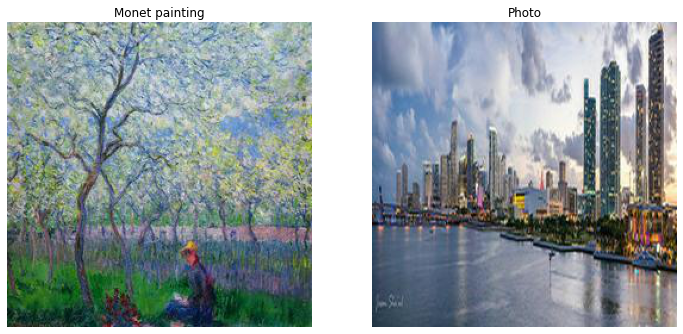

In [ ]:
monet_img, photo_img = next(iter(small_loader))
print(monet_img.shape)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(monet_img[0].permute(1, 2, 0) * 0.5 + 0.5)
plt.title("Monet painting")
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(photo_img[0].permute(1, 2, 0) * 0.5 + 0.5)
plt.title("Photo")
plt.axis(False);

In [ ]:
for epoch in tqdm(range(151, NUM_EPOCHS + 1)):
    train(disc_photo=d_photo,
          disc_monet=d_monet,
          gen_photo=g_photo,
          gen_monet=g_monet,
          opt_disc=optimizer_d,
          opt_gen=optimizer_g,
          loader=small_loader,
          l1=l1,
          mse=mse,
          d_scaler=d_scaler,
          g_scaler=g_scaler,
          epoch=epoch)
    if epoch > 100:
        scheduler_d.step()
        scheduler_g.step()
    if (epoch % 50 == 0) and SAVE_MODEL:
        save_load.save_current_state(d_monet, optimizer_d, CHECKPOINT_DISC_MONET)
        save_load.save_current_state(d_photo, optimizer_d, CHECKPOINT_DISC_PHOTO)
        save_load.save_current_state(g_monet, optimizer_g, CHECKPOINT_GEN_MONET)
        save_load.save_current_state(g_photo, optimizer_g, CHECKPOINT_GEN_PHOTO)

  0%|          | 0/50 [00:00<?, ?it/s]

Generator loss: 4.765525721708934 | Discriminator loss: 0.026467286252106228
Generator loss: 4.692459563414256 | Discriminator loss: 0.024822511677630246
Generator loss: 4.748001317183177 | Discriminator loss: 0.02203133367312451
Generator loss: 4.726315664450327 | Discriminator loss: 0.023925849157385527
Generator loss: 4.775166494846344 | Discriminator loss: 0.019867199844059845
Generator loss: 4.7463414422671 | Discriminator loss: 0.02258824764130016
Generator loss: 4.718136930465699 | Discriminator loss: 0.024262501484093566
Generator loss: 4.769923277695974 | Discriminator loss: 0.02468569643329829
Generator loss: 4.794358712037404 | Discriminator loss: 0.022695026815248032
Generator loss: 4.790570802688599 | Discriminator loss: 0.02205425063613802
Generator loss: 4.777648277282715 | Discriminator loss: 0.021311670701640348
Generator loss: 4.7914732948939 | Discriminator loss: 0.02018295120447874
Generator loss: 4.769025367101033 | Discriminator loss: 0.025403243435236315
Generato

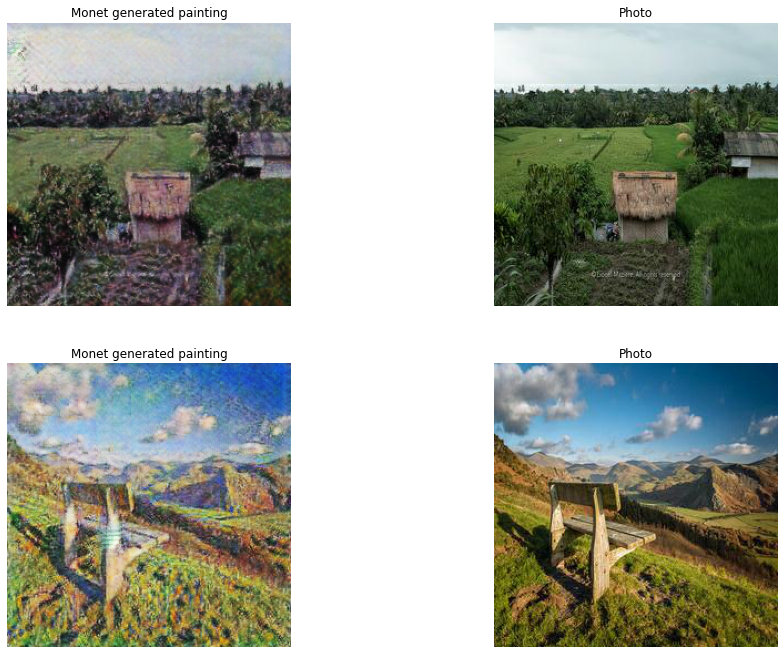

In [ ]:
plt.figure(figsize=(16, 24))

monet_img, photo_img = next(iter(small_loader))
photo_img = photo_img.to(DEVICE)
plt.subplot(4, 2, 1)
plt.imshow((g_monet(photo_img).detach().cpu().squeeze(dim=0).permute(1, 2, 0).numpy() * 127.5 + 127.5).astype(np.uint8))
# plt.imshow(g_monet(photo_img).detach().cpu()[0].permute(1, 2, 0) * 0.5 + 0.5)
plt.title("Monet generated painting")
plt.axis(False)
plt.subplot(4, 2, 2)
plt.imshow(photo_img.cpu()[0].permute(1, 2, 0) * 0.5 + 0.5)
plt.title("Photo")
plt.axis(False)

monet_img, photo_img = next(iter(small_loader))
photo_img = photo_img.to(DEVICE)
plt.subplot(4, 2, 3)
plt.imshow(g_monet(photo_img).detach().cpu()[0].permute(1, 2, 0) * 0.5 + 0.5)
plt.title("Monet generated painting")
plt.axis(False)
plt.subplot(4, 2, 4)
plt.imshow(photo_img.cpu()[0].permute(1, 2, 0) * 0.5 + 0.5)
plt.title("Photo")
plt.axis(False);

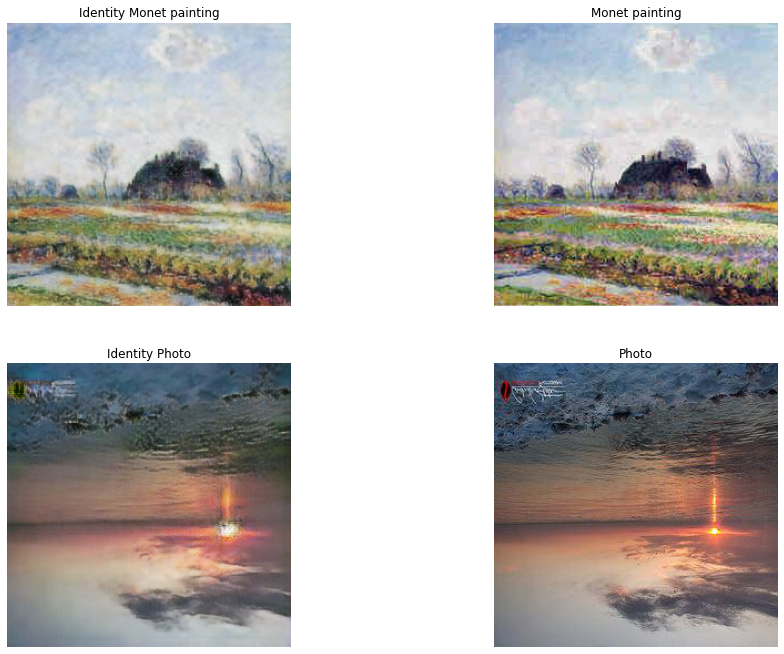

In [ ]:
plt.figure(figsize=(16, 24))

monet_img, photo_img = next(iter(small_loader))
photo_img = photo_img.to(DEVICE)
monet_img = monet_img.to(DEVICE)
plt.subplot(4, 2, 1)
plt.imshow(g_monet(monet_img).detach().cpu()[0].permute(1, 2, 0) * 0.5 + 0.5)
plt.title("Identity Monet painting")
plt.axis(False)
plt.subplot(4, 2, 2)
plt.imshow(monet_img.cpu()[0].permute(1, 2, 0) * 0.5 + 0.5)
plt.title("Monet painting")
plt.axis(False)

monet_img, photo_img = next(iter(small_loader))
photo_img = photo_img.to(DEVICE)
plt.subplot(4, 2, 3)
plt.imshow(g_photo(photo_img).detach().cpu()[0].permute(1, 2, 0) * 0.5 + 0.5)
plt.title("Identity Photo")
plt.axis(False)
plt.subplot(4, 2, 4)
plt.imshow(photo_img.cpu()[0].permute(1, 2, 0) * 0.5 + 0.5)
plt.title("Photo")
plt.axis(False);

In [ ]:
def gen_some_monet(path, model, device):
    transforms = alb.Compose(
        [
            alb.Resize(height=256, width=256),
            alb.Normalize(mean=(0.5, 0.5, 0.5),
                          std=(0.5, 0.5, 0.5),
                          max_pixel_value=255),
            pytorch.transforms.ToTensorV2(),
        ] # We can pass additional target and all augmentations will be applied to it
    )
    image_array = np.array(PIL.Image.open(path))
    augmented = transforms(image=image_array)
    image_tensor = augmented["image"].unsqueeze(dim=0).to(device)
    model.to(device)
    with torch.inference_mode():
        generated_monet = model(image_tensor)
    plt.figure(figsize=(16, 24))
    plt.subplot(1, 2, 1)
    plt.imshow(image_tensor.detach().cpu()[0].permute(1, 2, 0) * 0.5 + 0.5)
    plt.title("Original picture")
    plt.subplot(1, 2, 2)
    plt.imshow(generated_monet.detach().cpu()[0].permute(1, 2, 0) * 0.5 + 0.5)
    plt.title("Monet style picture")

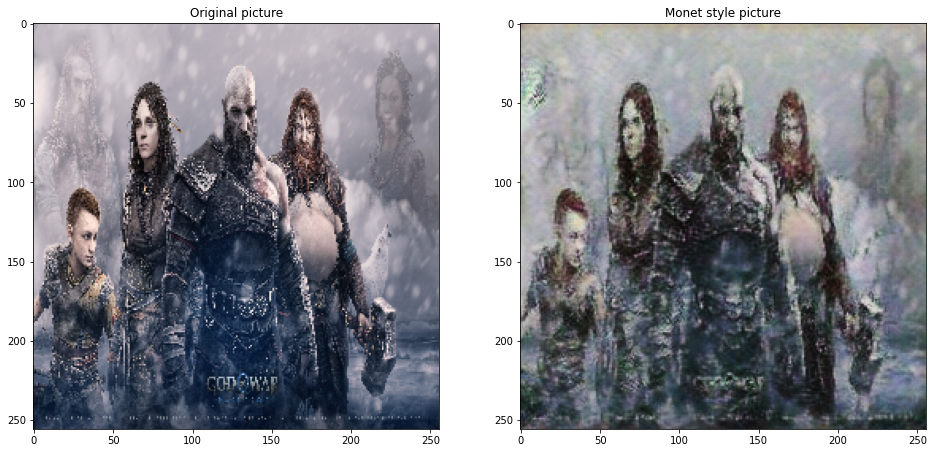

In [ ]:
gen_some_monet("drive/MyDrive/1209131.jpg", g_monet, DEVICE)

In [ ]:
# Submitting
default_transforms = alb.Compose(
    [
        alb.Normalize(mean=(0.5, 0.5, 0.5),
                      std=(0.5, 0.5, 0.5),
                      max_pixel_value=255),
        pytorch.transforms.ToTensorV2(),
    ],
    additional_targets={"image0": "image"}
)
all_dataset = dataset.MonetPhotoDataset(photo_path=PHOTO_DIR,
                                        monet_path=MONET_DIR,
                                        transforms=default_transforms,
                                        train=True,
                                        test_size=0.0)
all_loader = torch.utils.data.DataLoader(all_dataset,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=8)
print("All data shape:", len(all_dataset), "All loader shape:", len(all_loader))
make_submit(all_loader, g_monet, DEVICE)

All data shape: 7048 All loader shape: 7048


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(os.listdir("images"))

7048

In [ ]:
shutil.make_archive("MonetPhotoCompetition/images", 'zip', "images")

'/content/MonetPhotoCompetition/images.zip'

In [ ]:
def train(disc_photo, disc_monet, gen_photo, gen_monet, loader, opt_disc, opt_gen, l1, mse, g_scaler, d_scaler):
    disc_photo.train()
    disc_monet.train()
    gen_photo.train()
    gen_monet.train()
    for i, (monet_batch, photo_batch) in tqdm(enumerate(loader)):
        monet_batch = monet_batch.to(DEVICE)
        photo_batch = photo_batch.to(DEVICE)

        with torch.cuda.amp.autocast():
            # Generate fake photo from monet painting
            fake_photo = gen_photo(monet_batch)
            # Discriminate fake photo
            disc_photo_fake = disc_photo(fake_photo.detach())
            # Discriminate real photo
            disc_photo_real = disc_photo(photo_batch)
            # Calculate fake generated photo from monet painting discriminator loss
            disc_loss_photo_fake = mse(disc_photo_fake, torch.zeros_like(disc_photo_fake.detach()).to(DEVICE))
            # Calculate real photo discriminator loss
            disc_loss_photo_real = mse(disc_photo_real, torch.ones_like(disc_photo_real.detach()).to(DEVICE))
            disc_loss_photo = disc_loss_photo_fake + disc_loss_photo_real

            fake_monet = gen_monet(photo_batch)
            disc_monet_fake = disc_monet(fake_monet.detach())
            disc_monet_real = disc_monet(monet_batch)
            disc_loss_monet_fake = mse(disc_monet_fake, torch.zeros_like(disc_monet_fake.detach()).to(DEVICE))
            disc_loss_monet_real = mse(disc_monet_real, torch.ones_like(disc_monet_real.detach()).to(DEVICE))
            disc_loss_monet = disc_loss_monet_fake + disc_loss_monet_real

            disc_loss = (disc_loss_photo + disc_loss_monet) / 2
            opt_disc.zero_grad()
            d_scaler.scale(disc_loss).backward()
            d_scaler.step(opt_disc)
            d_scaler.update()

        with torch.cuda.amp.autocast():
            disc_photo_fake = disc_photo(fake_photo)
            disc_monet_fake = disc_monet(fake_monet)
            # Adversarial loss
            gen_loss_photo = mse(disc_photo_fake, torch.ones_like(disc_photo_fake).to(DEVICE))
            gen_loss_monet = mse(disc_monet_fake, torch.ones_like(disc_monet_fake).to(DEVICE))
            # Cycle loss, X (F)-> Y (G)-> X and Y (G)-> X (F)-> Y
            cycle_loss_photo = l1(gen_photo(fake_monet), photo_batch)
            cycle_loss_monet = l1(gen_monet(fake_photo), monet_batch)
            # Identity loss, X (G)-> X, Y (F)-> Y
            # identity_loss_photo = l1(gen_photo(photo_batch), photo_batch)
            # identity_loss_monet = l1(gen_monet(monet_batch), monet_batch)
            # Overall generator loss
            g_loss = gen_loss_photo + gen_loss_monet + \
                LAMBDA_CYCLE * cycle_loss_photo + LAMBDA_CYCLE * cycle_loss_monet # + \
                # LAMBDA_IDENTITY * identity_loss_photo + LAMBDA_IDENTITY * identity_loss_monet
            opt_gen.zero_grad()
            g_scaler.scale(g_loss).backward()
            g_scaler.step(opt_gen)
            g_scaler.update()

        if i % 256 == 0:
            print(f"Generator photo loss: {gen_loss_photo.item()} | Generator Monet loss: {gen_loss_monet.item()}")
            print("Saving generated images...", i)
            save_image(fake_photo.squeeze(dim=0) * 0.5 + 0.5, f"MonetPhotoCompetition/generated_images/fake_photo{i}.png")
            save_image(fake_monet.squeeze(dim=0) * 0.5 + 0.5, f"MonetPhotoCompetition/generated_images/fake_monet{i}.png")
            print("Saved generated images", i, end='\n\n')

In [ ]:
def main():
    d_monet = models.Discriminator(3, 64).to(DEVICE)
    d_photo = models.Discriminator(3, 64).to(DEVICE)
    g_monet = models.Generator(3, 64).to(DEVICE)
    g_photo = models.Generator(3, 64).to(DEVICE)
    optimizer_d = torch.optim.Adam(list(d_monet.parameters()) + list(d_photo.parameters()),
                                    lr=LEARNING_RATE,
                                    betas=(0.5, 0.999))
    optimizer_g = torch.optim.Adam(list(g_monet.parameters()) + list(g_photo.parameters()),
                                    lr=LEARNING_RATE,
                                    betas=(0.5, 0.999))

    l1 = nn.L1Loss()  # For cycle consistency and identity loss function
    mse = nn.MSELoss()  # For adversarial loss, maybe try log loss later

    train_dataset = dataset.MonetPhotoDataset(photo_path=PHOTO_DIR,
                                              monet_path=MONET_DIR,
                                              transforms=TRANSFORMS)
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in tqdm(range(NUM_EPOCHS)):
        train(disc_photo=d_photo,
              disc_monet=d_monet,
              gen_photo=g_photo,
              gen_monet=g_monet,
              opt_disc=optimizer_d,
              opt_gen=optimizer_g,
              loader=train_loader,
              l1=l1,
              mse=mse,
              d_scaler=d_scaler,
              g_scaler=g_scaler)
        if SAVE_MODEL:
            save_load.save_current_state(d_monet, optimizer_d, CHECKPOINT_DISC_MONET)
            save_load.save_current_state(d_photo, optimizer_d, CHECKPOINT_DISC_PHOTO)
            save_load.save_current_state(g_monet, optimizer_g, CHECKPOINT_GEN_MONET)
            save_load.save_current_state(g_photo, optimizer_g, CHECKPOINT_GEN_PHOTO)

In [ ]:
!nvidia-smi

Tue Aug 30 12:01:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
main()

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Generator photo loss: 0.3281231224536896 | Generator Monet loss: 0.2629300355911255
Saving generated images... 0
Saved generated images 0

Generator photo loss: 0.4290643334388733 | Generator Monet loss: 0.5571343898773193
Saving generated images... 256
Saved generated images 256

Generator photo loss: 0.7542441487312317 | Generator Monet loss: 0.6034831404685974
Saving generated images... 512
Saved generated images 512

Generator photo loss: 0.5159360766410828 | Generator Monet loss: 0.6356889009475708
Saving generated images... 768
Saved generated images 768

Generator photo loss: 0.5432705283164978 | Generator Monet loss: 0.9122827649116516
Saving generated images... 1024
Saved generated images 1024

Generator photo loss: 0.5074207782745361 | Generator Monet loss: 0.5815223455429077
Saving generated images... 1280
Saved generated images 1280

Generator photo loss: 0.6620501279830933 | Generator Monet loss: 0.7107870578765869
Saving generated images... 1536
Saved generated images 153

0it [00:00, ?it/s]

Generator photo loss: 0.2832728624343872 | Generator Monet loss: 0.7434993386268616
Saving generated images... 0
Saved generated images 0

Generator photo loss: 0.2975645661354065 | Generator Monet loss: 0.5836449265480042
Saving generated images... 256
Saved generated images 256

Generator photo loss: 0.7863777279853821 | Generator Monet loss: 0.6843889355659485
Saving generated images... 512
Saved generated images 512

Generator photo loss: 0.6574361324310303 | Generator Monet loss: 0.5855708718299866
Saving generated images... 768
Saved generated images 768

Generator photo loss: 0.702551543712616 | Generator Monet loss: 0.7407450675964355
Saving generated images... 1024
Saved generated images 1024

Generator photo loss: 0.5893372893333435 | Generator Monet loss: 0.5495017170906067
Saving generated images... 1280
Saved generated images 1280

Generator photo loss: 0.684418797492981 | Generator Monet loss: 0.8232694268226624
Saving generated images... 1536
Saved generated images 1536


0it [00:00, ?it/s]

Generator photo loss: 0.43590089678764343 | Generator Monet loss: 0.882505476474762
Saving generated images... 0
Saved generated images 0

Generator photo loss: 0.6706267595291138 | Generator Monet loss: 0.8004866242408752
Saving generated images... 256
Saved generated images 256

Generator photo loss: 0.34646427631378174 | Generator Monet loss: 0.9310610890388489
Saving generated images... 512
Saved generated images 512

Generator photo loss: 0.7088105082511902 | Generator Monet loss: 0.9538952708244324
Saving generated images... 768
Saved generated images 768

Generator photo loss: 0.6888028979301453 | Generator Monet loss: 0.8564682602882385
Saving generated images... 1024
Saved generated images 1024

Generator photo loss: 0.44852060079574585 | Generator Monet loss: 0.9052475690841675
Saving generated images... 1280
Saved generated images 1280

Generator photo loss: 0.6099392771720886 | Generator Monet loss: 0.9514276385307312
Saving generated images... 1536
Saved generated images 1

0it [00:00, ?it/s]

Generator photo loss: 0.514980137348175 | Generator Monet loss: 0.9914873242378235
Saving generated images... 0
Saved generated images 0

Generator photo loss: 0.5854136943817139 | Generator Monet loss: 0.9994321465492249
Saving generated images... 256
Saved generated images 256

Generator photo loss: 0.3713200092315674 | Generator Monet loss: 0.9998200535774231
Saving generated images... 512
Saved generated images 512

Generator photo loss: 0.4749780595302582 | Generator Monet loss: 0.9998613595962524
Saving generated images... 768
Saved generated images 768

Generator photo loss: 0.4611539840698242 | Generator Monet loss: 0.9997532367706299
Saving generated images... 1024
Saved generated images 1024

Generator photo loss: 0.4540526866912842 | Generator Monet loss: 0.9995145797729492
Saving generated images... 1280
Saved generated images 1280

Generator photo loss: 0.5210567116737366 | Generator Monet loss: 0.999975323677063
Saving generated images... 1536
Saved generated images 1536


0it [00:00, ?it/s]

Generator photo loss: 0.49744704365730286 | Generator Monet loss: 0.9999399185180664
Saving generated images... 0
Saved generated images 0

Generator photo loss: 0.6362197399139404 | Generator Monet loss: 0.9981663823127747
Saving generated images... 256
Saved generated images 256

Generator photo loss: 0.7784249186515808 | Generator Monet loss: 0.9982572197914124
Saving generated images... 512
Saved generated images 512

Generator photo loss: 0.7562962770462036 | Generator Monet loss: 0.9993131756782532
Saving generated images... 768
Saved generated images 768

Generator photo loss: 0.7080287337303162 | Generator Monet loss: 0.9996045827865601
Saving generated images... 1024
Saved generated images 1024

Generator photo loss: 0.615932285785675 | Generator Monet loss: 0.9993462562561035
Saving generated images... 1280
Saved generated images 1280

Generator photo loss: 0.8070514798164368 | Generator Monet loss: 0.9999985098838806
Saving generated images... 1536
Saved generated images 153

0it [00:00, ?it/s]

Generator photo loss: 0.8435760140419006 | Generator Monet loss: 0.9999948740005493
Saving generated images... 0
Saved generated images 0

Generator photo loss: 0.8523582816123962 | Generator Monet loss: 0.9999889135360718
Saving generated images... 256
Saved generated images 256

Generator photo loss: 0.6644304990768433 | Generator Monet loss: 0.9999679923057556
Saving generated images... 512
Saved generated images 512

Generator photo loss: 0.7162138819694519 | Generator Monet loss: 0.9999904632568359
Saving generated images... 768
Saved generated images 768

Generator photo loss: 0.7872382998466492 | Generator Monet loss: 0.9999959468841553
Saving generated images... 1024
Saved generated images 1024

Generator photo loss: 0.786022961139679 | Generator Monet loss: 0.9999978542327881
Saving generated images... 1280
Saved generated images 1280

Generator photo loss: 0.8242501020431519 | Generator Monet loss: 0.9999863505363464
Saving generated images... 1536
Saved generated images 1536

0it [00:00, ?it/s]

Generator photo loss: 0.9399564266204834 | Generator Monet loss: 0.9998753666877747
Saving generated images... 0
Saved generated images 0

Generator photo loss: 0.9206094145774841 | Generator Monet loss: 0.999922513961792
Saving generated images... 256
Saved generated images 256

Generator photo loss: 0.8924810290336609 | Generator Monet loss: 0.9999998807907104
Saving generated images... 512
Saved generated images 512

Generator photo loss: 0.8875063061714172 | Generator Monet loss: 0.9999998807907104
Saving generated images... 768
Saved generated images 768

Generator photo loss: 0.9488216638565063 | Generator Monet loss: 0.9999958276748657
Saving generated images... 1024
Saved generated images 1024

Generator photo loss: 0.8356237411499023 | Generator Monet loss: 0.999999463558197
Saving generated images... 1280
Saved generated images 1280

Generator photo loss: 0.8713274598121643 | Generator Monet loss: 0.999998927116394
Saving generated images... 1536
Saved generated images 1536



0it [00:00, ?it/s]

Generator photo loss: 0.9907991886138916 | Generator Monet loss: 0.9999997019767761
Saving generated images... 0
Saved generated images 0

Generator photo loss: 0.9412127137184143 | Generator Monet loss: 0.999999463558197
Saving generated images... 256
Saved generated images 256

Generator photo loss: 0.998171329498291 | Generator Monet loss: 0.9999998807907104
Saving generated images... 512
Saved generated images 512

Generator photo loss: 0.951942503452301 | Generator Monet loss: 0.9978427886962891
Saving generated images... 768
Saved generated images 768

Generator photo loss: 0.9208924770355225 | Generator Monet loss: 0.9988012909889221
Saving generated images... 1024
Saved generated images 1024

Generator photo loss: 0.901988685131073 | Generator Monet loss: 0.9999366998672485
Saving generated images... 1280
Saved generated images 1280

Generator photo loss: 0.8428556323051453 | Generator Monet loss: 0.9999613761901855
Saving generated images... 1536
Saved generated images 1536

G

0it [00:00, ?it/s]

Generator photo loss: 0.9508153200149536 | Generator Monet loss: 0.9999927878379822
Saving generated images... 0
Saved generated images 0

Generator photo loss: 0.9385108947753906 | Generator Monet loss: 0.9999940395355225
Saving generated images... 256
Saved generated images 256

Generator photo loss: 0.9739773273468018 | Generator Monet loss: 0.9999998211860657
Saving generated images... 512
Saved generated images 512

Generator photo loss: 0.9477929472923279 | Generator Monet loss: 0.9999963641166687
Saving generated images... 768
Saved generated images 768

Generator photo loss: 0.9597352147102356 | Generator Monet loss: 0.9999998807907104
Saving generated images... 1024
Saved generated images 1024

Generator photo loss: 0.9806268811225891 | Generator Monet loss: 0.9999980330467224
Saving generated images... 1280
Saved generated images 1280

Generator photo loss: 0.9728384017944336 | Generator Monet loss: 0.9999996423721313
Saving generated images... 1536
Saved generated images 153

0it [00:00, ?it/s]

Generator photo loss: 0.8839715123176575 | Generator Monet loss: 1.0
Saving generated images... 0
Saved generated images 0

Generator photo loss: 0.967857837677002 | Generator Monet loss: 0.999998152256012
Saving generated images... 256
Saved generated images 256

Generator photo loss: 0.9839047789573669 | Generator Monet loss: 0.999996542930603
Saving generated images... 512
Saved generated images 512

Generator photo loss: 0.9943050146102905 | Generator Monet loss: 0.9999998807907104
Saving generated images... 768
Saved generated images 768

Generator photo loss: 0.9935110807418823 | Generator Monet loss: 0.9999998807907104
Saving generated images... 1024
Saved generated images 1024

Generator photo loss: 0.8272027373313904 | Generator Monet loss: 0.9999606013298035
Saving generated images... 1280
Saved generated images 1280

Generator photo loss: 0.9279828667640686 | Generator Monet loss: 0.9999943375587463
Saving generated images... 1536
Saved generated images 1536

Generator photo

0it [00:00, ?it/s]

Generator photo loss: 0.9815695881843567 | Generator Monet loss: 0.9999958872795105
Saving generated images... 0
Saved generated images 0

Generator photo loss: 0.9376983046531677 | Generator Monet loss: 0.9999992251396179
Saving generated images... 256
Saved generated images 256

Generator photo loss: 0.9554724097251892 | Generator Monet loss: 1.0
Saving generated images... 512
Saved generated images 512

Generator photo loss: 0.9375380277633667 | Generator Monet loss: 0.9999986886978149
Saving generated images... 768
Saved generated images 768

Generator photo loss: 0.9866042733192444 | Generator Monet loss: 0.999825119972229
Saving generated images... 1024
Saved generated images 1024

Generator photo loss: 0.9950305819511414 | Generator Monet loss: 0.9999996423721313
Saving generated images... 1280
Saved generated images 1280

Generator photo loss: 0.983647882938385 | Generator Monet loss: 0.9999997019767761
Saving generated images... 1536
Saved generated images 1536

Generator phot